In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from random import uniform
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1)
        )
        self.init_bias()
    def forward(self,x):
        x=self.net(x)
        return x
    def init_bias(self):
        for layer in self.net.children():
            if isinstance(layer, nn.Linear):
                # 权重采用Xavier正态初始化
                nn.init.xavier_normal_(layer.weight, gain=5 / 3)
                # 偏置置0
                nn.init.constant_(layer.bias, 0.)

In [3]:
def u_function(x):
    u = model(x)
    return u

def f_function(x, v, v_e, Epsilon, K ,g):
    u = u_function(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    f = -v_e / Epsilon * u_xx + v * u / K - g
    return f

def Loss(x_f, v, v_e, Epsilon, K, g, H):
    f_pre = f_function(x_f, v, v_e, Epsilon, K ,g)
    null =  torch.zeros((x_f.shape[0], 1))
    f_loss = loss_fn(f_pre, null)
    
    u_0 = u_function(torch.tensor(0,dtype=torch.float32).reshape(-1,1))
    u_H = u_function(torch.tensor(H,dtype=torch.float32).reshape(-1,1))
    x_u = torch.cat([u_0, u_H],0)
    null = torch.tensor([0, 0],dtype=torch.float32).reshape(-1,1)
    u_loss = loss_fn(x_u,null)
    ls = f_loss + u_loss
    ls.backward()
    return ls

[Epoch 1/2000] [loss: 5.948857307434082]
[Epoch 101/2000] [loss: 0.08988773822784424]
[Epoch 201/2000] [loss: 0.039150580763816833]
[Epoch 301/2000] [loss: 0.02736496739089489]
[Epoch 401/2000] [loss: 0.03528645634651184]
[Epoch 501/2000] [loss: 0.0837731584906578]
[Epoch 601/2000] [loss: 0.0046555353328585625]
[Epoch 701/2000] [loss: 0.002227537566795945]
[Epoch 801/2000] [loss: 0.0020588072948157787]
[Epoch 901/2000] [loss: 0.0005576115800067782]
[Epoch 1001/2000] [loss: 0.00024377206864301115]
[Epoch 1101/2000] [loss: 0.0001963514951057732]
[Epoch 1201/2000] [loss: 0.00016676653467584401]
[Epoch 1301/2000] [loss: 0.00014700800238642842]
[Epoch 1401/2000] [loss: 0.0001330331724602729]
[Epoch 1501/2000] [loss: 0.00012265493569429964]
[Epoch 1601/2000] [loss: 0.00011461393296485767]
[Epoch 1701/2000] [loss: 0.00010816211579367518]
[Epoch 1801/2000] [loss: 0.00010283668234478682]
[Epoch 1901/2000] [loss: 9.833941294346005e-05]


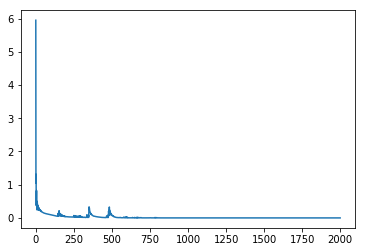

In [4]:
H = 1
v_e = 10 ** -3
v = 10 ** -3
Epsilon = 0.4
K = 10 ** -3
g = 1
r = np.sqrt((v * Epsilon) / (v_e * K))
def Exact_f(x, H = torch.tensor(H), v = torch.tensor(v), K = torch.tensor(K), g = torch.tensor(g), r = torch.tensor(r)):
    f = g * K / v * (1 - torch.cosh(r * (x - H / 2)) / torch.cosh(r * H / 2))
    return f
# 制造数据点集
N_f = 10000
x_f = np.random.rand(N_f, 1) * H
x_f = torch.tensor(x_f.reshape(-1, 1), dtype=torch.float32, requires_grad=True)
# 模型训练
model=MLP()
loss_fn = nn.MSELoss()  #均方差做损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9, verbose=False) # 动态递减学习率
epochs = 2000
Losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = Loss(x_f, v, v_e, Epsilon, K, g, H)
    Losses.append(loss.item())
    if epoch % 100 ==0:
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
    optimizer.step()
    scheduler.step()
plt.plot(Losses)
plt.show()

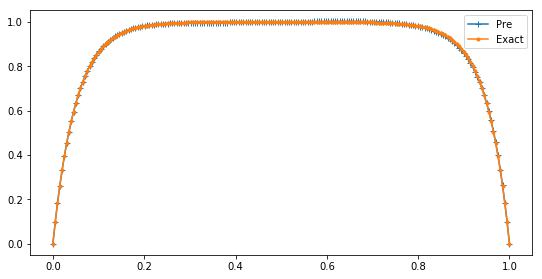

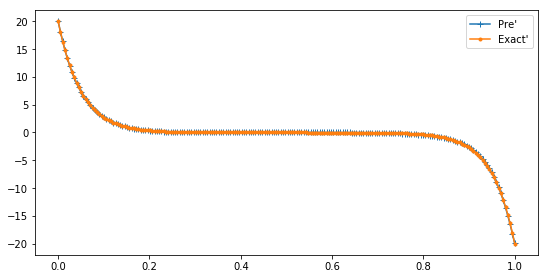

In [5]:
# 可视化
x = torch.linspace(0, 1, 200, dtype=torch.float32).reshape(-1,1).requires_grad_()
u_pre = u_function(x).reshape(-1,1)
u_exact = Exact_f(x)
xnp = x.detach().numpy()
Unp = u_pre.detach().numpy()
Uex = u_exact.detach().numpy()
# plot:
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)
plt.plot(xnp,Unp,marker='+',label='Pre')
plt.plot(xnp,Uex,marker='.',label='Exact')
plt.legend()
plt.show()
ux_pre = torch.autograd.grad(u_pre, x, torch.ones_like(u_pre), retain_graph=True, create_graph=True)[0]
ux_exact = torch.autograd.grad(Exact_f(x), x, torch.ones_like(Exact_f(x)), retain_graph=True, create_graph=True)[0]
Uxnp = ux_pre.detach().numpy()
Uxex = ux_exact.detach().numpy()
# plot:
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)
plt.plot(xnp,Uxnp,marker='+',label='Pre\'')
plt.plot(xnp,Uxex,marker='.',label='Exact\'')
plt.legend()
plt.show()